# Sentiment Analysis on Twitter Data with RNNs


## Load and Explore the Dataset


In [5]:
import pandas as pd
df = pd.read_csv('sentiment140', encoding='latin1')  # Replace 'latin1' if necessary
df.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


## Clean and Preprocess Text Data


In [6]:
df.columns = ['polarity', 'id','date', 'query', 'user', 'text_tweet']

In [7]:
df['polarity'].value_counts()

polarity
4    800000
0    799999
Name: count, dtype: int64

In [8]:
percent_missing = df.isnull().sum() * 100 / len(df)
percent_missing

polarity      0.0
id            0.0
date          0.0
query         0.0
user          0.0
text_tweet    0.0
dtype: float64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   polarity    1599999 non-null  int64 
 1   id          1599999 non-null  int64 
 2   date        1599999 non-null  object
 3   query       1599999 non-null  object
 4   user        1599999 non-null  object
 5   text_tweet  1599999 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [15]:
import re

df['text_tweet'] = df['text_tweet'].apply(lambda x: re.sub(r'[^A-Za-z0-9]+',' ',x))

df['text_tweet'] = df['text_tweet'].apply(lambda x: re.sub(r"\n", " ", x))
                                                                         
df['text_tweet'] = df['text_tweet'].apply(lambda x: re.sub(r'\b[a-zA-Z]{1,2}\b', '', x))

In [30]:
# normalized polarity
# 0 = negative
# 1 = positve (4 before)

df['polarity'] = df['polarity'].replace({4: 1})

In [ ]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

## Train-Test Split


In [32]:
X = df['text_tweet'].values
y = df['polarity'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

## Baseline GRU Model

In [33]:
VOCAB_SIZE = 1000

encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE
)

encoder.adapt(X_train)

In [34]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  
])


In [35]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [38]:
%%time
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=64,
    epochs=10,
    validation_data=(X_test, y_test),
    callbacks=[callback],
    verbose=1
)


Epoch 1/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 832s 41ms/step - accuracy: 0.7438 - loss: 0.5138 - val_accuracy: 0.7670 - val_loss: 0.4760
Epoch 2/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 791s 40ms/step - accuracy: 0.7688 - loss: 0.4724 - val_accuracy: 0.7725 - val_loss: 0.4674
Epoch 3/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 770s 38ms/step - accuracy: 0.7751 - loss: 0.4638 - val_accuracy: 0.7744 - val_loss: 0.4631
Epoch 4/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 720s 36ms/step - accuracy: 0.7785 - loss: 0.4585 - val_accuracy: 0.7782 - val_loss: 0.4578
Epoch 5/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 750s 36ms/step - accuracy: 0.7813 - loss: 0.4538 - val_accuracy: 0.7810 - val_loss: 0.4534
Epoch 6/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 709s 35ms/step - accuracy: 0.7833 - loss: 0.4501 - val_accuracy: 0.7817 - val_loss: 0.4532
Epoch 7/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 715s 36ms/step - accuracy: 0.7866 - loss: 0.4459 - val_accuracy: 0.7835 - val_loss: 0.4490
Epoch 8/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 767s 38ms/s

%%time
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience= 5)
epochs= 100
history = model.fit(
  train_data,
  validation_data=val_data,
  epochs=epochs,
  callbacks=[callback], verbose = 1
)

## Evaluate GRU Model

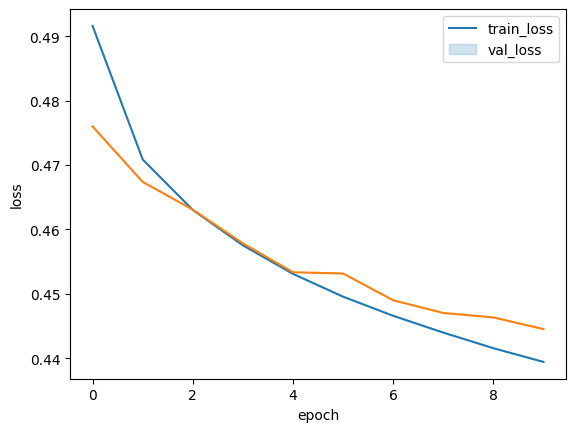

In [39]:
train_history = pd.DataFrame(history.history)

train_history['epoch'] = history.epoch

sns.lineplot(x='epoch', y ='loss', data =train_history)

sns.lineplot(x='epoch', y ='val_loss', data =train_history)

plt.legend(labels=['train_loss', 'val_loss'])

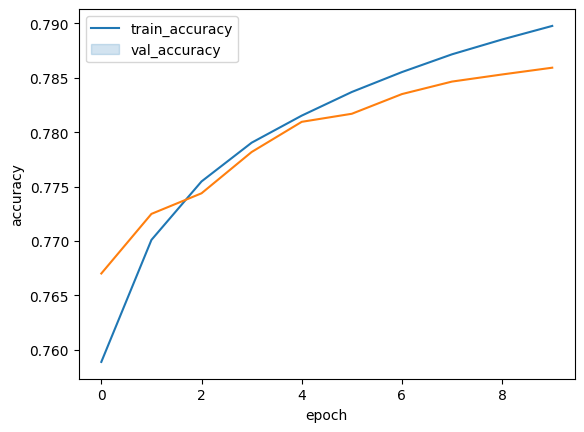

In [40]:
sns.lineplot(x='epoch', y ='accuracy', data =train_history)

sns.lineplot(x='epoch', y ='val_accuracy', data =train_history)

plt.legend(labels=['train_accuracy', 'val_accuracy'])

In [41]:
y_pred = (model.predict(X_test)> 0.5).astype(int)

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 89s 9ms/step


In [42]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[124075,  35925],
       [ 32576, 127424]], dtype=int64)

In [43]:
from sklearn.metrics import classification_report
label_names = ['negative', 'positive']
print(classification_report(y_test, y_pred, target_names=label_names))

              precision    recall  f1-score   support

    negative       0.79      0.78      0.78    160000
    positive       0.78      0.80      0.79    160000

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



## LSTM Model


In [44]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

In [45]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [46]:
%%time
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=64,
    epochs=10,
    validation_data=(X_test, y_test),
    callbacks=[callback],
    verbose=1
)


Epoch 1/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 771s 38ms/step - accuracy: 0.7449 - loss: 0.5138 - val_accuracy: 0.7642 - val_loss: 0.4792
Epoch 2/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 686s 34ms/step - accuracy: 0.7664 - loss: 0.4765 - val_accuracy: 0.7699 - val_loss: 0.4707
Epoch 3/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 714s 36ms/step - accuracy: 0.7716 - loss: 0.4683 - val_accuracy: 0.7753 - val_loss: 0.4632
Epoch 4/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 702s 35ms/step - accuracy: 0.7771 - loss: 0.4601 - val_accuracy: 0.7779 - val_loss: 0.4597
Epoch 5/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 720s 36ms/step - accuracy: 0.7796 - loss: 0.4558 - val_accuracy: 0.7796 - val_loss: 0.4553
Epoch 6/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 725s 36ms/step - accuracy: 0.7822 - loss: 0.4516 - val_accuracy: 0.7811 - val_loss: 0.4524
Epoch 7/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 710s 35ms/step - accuracy: 0.7844 - loss: 0.4479 - val_accuracy: 0.7824 - val_loss: 0.4508
Epoch 8/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 764s 37ms/s

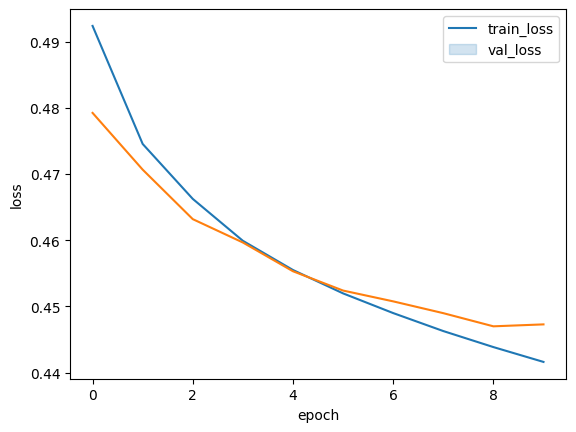

In [47]:
train_history = pd.DataFrame(history.history)

train_history['epoch'] = history.epoch

sns.lineplot(x='epoch', y ='loss', data =train_history)

sns.lineplot(x='epoch', y ='val_loss', data =train_history)

plt.legend(labels=['train_loss', 'val_loss'])

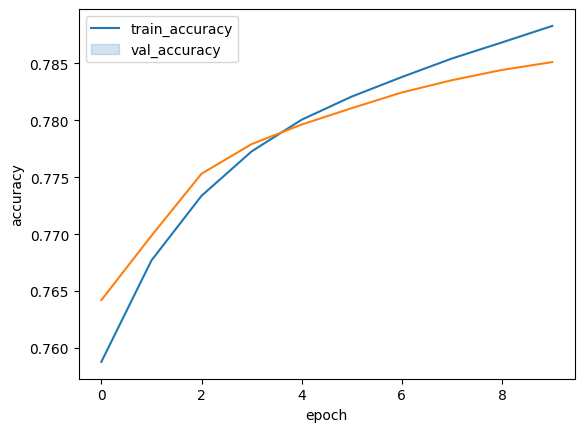

In [48]:
sns.lineplot(x='epoch', y ='accuracy', data =train_history)

sns.lineplot(x='epoch', y ='val_accuracy', data =train_history)

plt.legend(labels=['train_accuracy', 'val_accuracy'])

In [49]:
y_pred = (model.predict(X_test)> 0.5).astype(int)

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 89s 9ms/step


In [50]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[128236,  31764],
       [ 37001, 122999]], dtype=int64)

In [51]:
from sklearn.metrics import classification_report
label_names = ['negative', 'positive']
print(classification_report(y_test, y_pred, target_names=label_names))

              precision    recall  f1-score   support

    negative       0.78      0.80      0.79    160000
    positive       0.79      0.77      0.78    160000

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



## Third RNN model using embedding layer and GRU and LSTM

In [52]:
model = tf.keras.Sequential([
    encoder, 
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [53]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [54]:
%%time
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=64,
    epochs=10,
    validation_data=(X_test, y_test),
    callbacks=[callback],
    verbose=1
)


Epoch 1/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 1601s 80ms/step - accuracy: 0.7162 - loss: 0.5754 - val_accuracy: 0.7585 - val_loss: 0.4999
Epoch 2/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 1653s 83ms/step - accuracy: 0.7624 - loss: 0.4969 - val_accuracy: 0.7656 - val_loss: 0.5024
Epoch 3/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 1803s 88ms/step - accuracy: 0.7691 - loss: 0.4836 - val_accuracy: 0.7710 - val_loss: 0.4789
Epoch 4/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 2017s 101ms/step - accuracy: 0.7743 - loss: 0.4757 - val_accuracy: 0.7755 - val_loss: 0.4725
Epoch 5/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 1955s 98ms/step - accuracy: 0.7745 - loss: 0.4755 - val_accuracy: 0.7762 - val_loss: 0.4775
Epoch 6/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 1772s 89ms/step - accuracy: 0.7799 - loss: 0.4675 - val_accuracy: 0.7785 - val_loss: 0.4664
Epoch 7/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 1785s 89ms/step - accuracy: 0.7809 - loss: 0.4621 - val_accuracy: 0.7803 - val_loss: 0.4622
Epoch 8/10
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 185

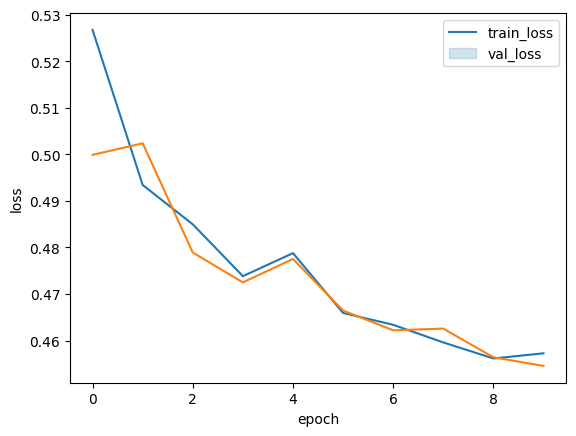

In [55]:
train_history = pd.DataFrame(history.history)

train_history['epoch'] = history.epoch

sns.lineplot(x='epoch', y ='loss', data =train_history)

sns.lineplot(x='epoch', y ='val_loss', data =train_history)

plt.legend(labels=['train_loss', 'val_loss'])

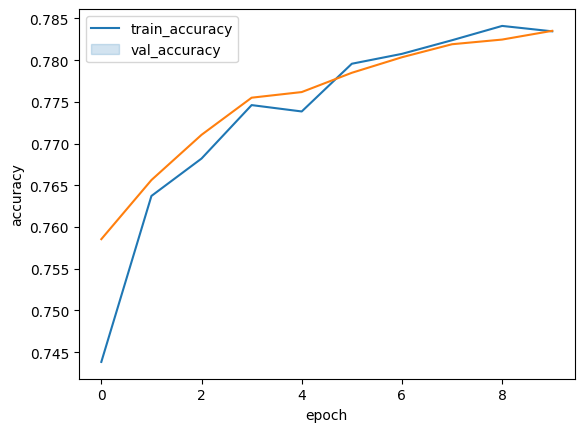

In [56]:
sns.lineplot(x='epoch', y ='accuracy', data =train_history)

sns.lineplot(x='epoch', y ='val_accuracy', data =train_history)

plt.legend(labels=['train_accuracy', 'val_accuracy'])

In [57]:
y_pred = (model.predict(X_test)> 0.5).astype(int)

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 189s 19ms/step


In [58]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[122405,  37595],
       [ 31681, 128319]], dtype=int64)

In [59]:
from sklearn.metrics import classification_report
label_names = ['negative', 'positive']
print(classification_report(y_test, y_pred, target_names=label_names))

              precision    recall  f1-score   support

    negative       0.79      0.77      0.78    160000
    positive       0.77      0.80      0.79    160000

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



## Summary

- GRU model achieved ~78.5% accuracy on test data
- LSTM model showed comparable performance
- Further improvement could be done using pre-trained embeddings (e.g., GloVe) or BERT-based models